In [25]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from forecastingGDP.data import get_data,get_series_info,clear_cache
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.interpolate import interp1d
from sklearn.model_selection import TimeSeriesSplit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [26]:
df_m = get_data(frequency='MS', use_cache=True)
df_q = get_data('QS-Jan', use_cache=True)
df_w = get_data('W-Sun', use_cache=True)

In [27]:
df_w=df_w.loc[df_w.index>='1971-01']
df_w=df_w.loc[df_w.index<='2020-01']

In [28]:
data_info=[]
for i in df_w.columns:
    data_info.append(get_series_info(i))   

In [91]:
df_w.tail()

,GDPC1,INDPRO,TCU,CFNAI,DSPIC96,PCE,U1RATE,CE16OV,PAYEMS,CPIAUCSL,PCEPILFE,PPIACO,IMPGSC1,EXPGSC1,GS10
2019-12-01,-0.000978,101.61790,76.5336,-0.280,14960.2,14796.30,1.2,158735.0,151919.0,258.2030,112.7530,199.00,3335.503077,2519.232462,1.86
2019-12-08,-0.000979,101.51268,76.4517,-0.244,14982.2,14813.14,1.2,158719.8,151982.0,258.2998,112.7922,199.06,3325.024462,2514.405769,1.84
2019-12-15,-0.000980,101.40746,76.3698,-0.208,15004.2,14829.98,1.2,158704.6,152045.0,258.3966,112.8314,199.12,3314.545846,2509.579077,1.82
2019-12-22,-0.000981,101.30224,76.2879,-0.172,15026.2,14846.82,1.2,158689.4,152108.0,258.4934,112.8706,199.18,3304.067231,2504.752385,1.80
2019-12-29,-0.000982,101.19702,76.2060,-0.136,15048.2,14863.66,1.2,158674.2,152171.0,258.5902,112.9098,199.24,3293.588615,2499.925692,1.78


In [30]:
data_info=pd.DataFrame(data_info)
data_info=data_info.set_index('id')

In [31]:
#Info and Missing Values %
percent_missing = df_w.isnull().sum() * 100 / len(df_w)
observation_start=data_info['observation_start']
observation_end=data_info['observation_end']
frequency=data_info['frequency_short']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info

,observation_start,observation_end,frequency,percent_missing
ATLSBUSRGEP,2016-12-01,2021-06-01,M,93.703559
SP500,2011-07-05,2021-07-02,D,82.675010
DTWEXAFEGS,2006-01-02,2021-06-25,D,71.450919
BAMLH0A0HYM2,1996-12-31,2021-07-01,D,53.070004
LNU05026648,1994-01-01,2021-06-01,M,46.929996
DGORDER,1992-02-01,2021-05-01,M,43.019163
MARTSMPCSM44000USS,1992-02-01,2021-05-01,M,43.019163
AMTMNO,1992-02-01,2021-05-01,M,43.019163
VIXCLS,1990-01-02,2021-07-01,D,38.795463
IMPCH,1985-01-01,2021-05-01,M,28.588189


In [32]:
for i in df_w.columns:
    if df_w[i].isna().sum()!=0:
        df_w=df_w.drop(columns=i)

In [33]:
#Convert GDP to GDP change %
df_w['GDPC1']=df_w['GDPC1'].pct_change()

In [34]:
df_w=df_w.dropna()

In [35]:
#Info and Missing Values %
percent_missing = df_w.isnull().sum() * 100 / len(df_w)
observation_start=data_info['observation_start']
observation_end=data_info['observation_end']
frequency=data_info['frequency_short']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info.dropna()

,observation_start,observation_end,frequency,percent_missing
CE16OV,1948-01-01,2021-06-01,M,0.0
CFNAI,1967-03-01,2021-05-01,M,0.0
CPIAUCSL,1947-01-01,2021-05-01,M,0.0
DSPIC96,1959-01-01,2021-05-01,M,0.0
EXPGSC1,1947-01-01,2021-01-01,Q,0.0
GDPC1,1947-01-01,2021-01-01,Q,0.0
GS10,1953-04-01,2021-06-01,M,0.0
IMPGSC1,1947-01-01,2021-01-01,Q,0.0
INDPRO,1919-01-01,2021-05-01,M,0.0
PAYEMS,1939-01-01,2021-06-01,M,0.0


In [36]:
#Starting and ending date
print(f'Start: {df_w.index[0]}')
print(f'End: {df_w.index[-1]}')
print(f'Shape: {df_w.shape}')

Start: 1971-01-10 00:00:00
End: 2019-12-29 00:00:00
Shape: (2556, 15)


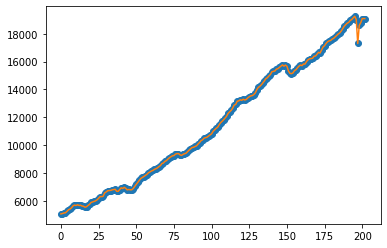

In [37]:
#Interpolation test on GDPC1
X=np.arange(0, len(df_q))
y=df_q['GDPC1'].dropna()
f = interp1d(X, y)
xnew = np.arange(0, len(df_q)-1, (1/3))
ynew = f(xnew)
plt.plot(X, y, 'o', xnew, ynew, '-')
plt.show()

In [38]:
def interpolation():
    
    '''Create a linear interpolation of missing data'''
    for i in df_info.index:
        if df_info.loc[i]['frequency']=='Q':
            
            X=np.arange(0, len(data[i].dropna()))
            y=data[i].dropna()
            f = interp1d(X, y)
            xnew = np.arange(0, len(data[i].dropna())-1, (1/3))
            ynew = f(xnew)
            df_test.drop(columns=[i])
            df_test[i]=ynew
            
    return df_test

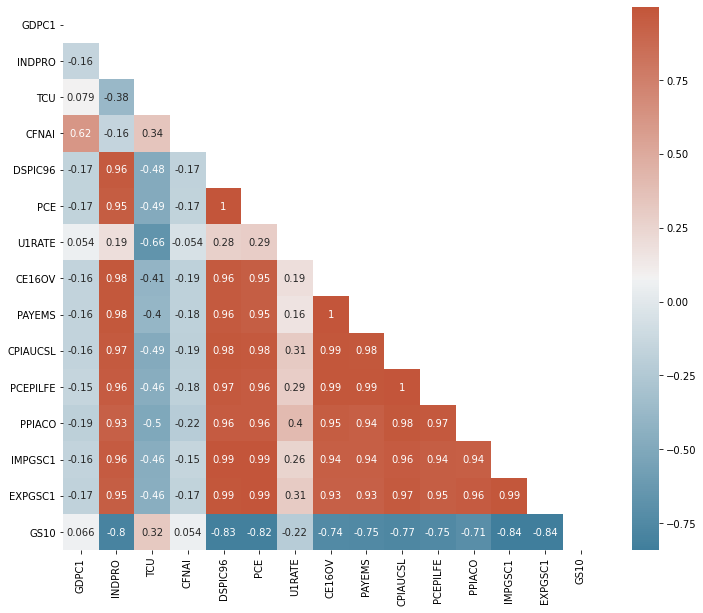

In [39]:
corr = df_w.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap);

#### df_train & df_test split

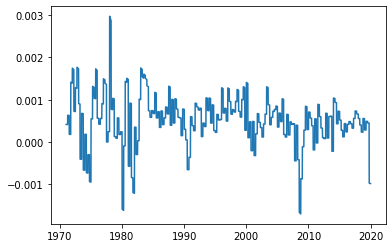

In [90]:
plt.plot(df_w['GDPC1'])

In [41]:
# Time Serie split 
#We separate df into df_train and df_test such that the first 80% of the dataframe are in the training. 
#And the last 20% in the test set.

len_ = int(0.6*df_w.shape[0])
df_train = df_w[:len_]
df_test = df_w[len_:len_+int(len(df_w[len_:])/2)]
df_val=df_w[len_+int(len(df_w[len_:])/2):]
assert df_train.shape[0]+df_test.shape[0]+df_val.shape[0] == df_w.shape[0]

In [42]:
# Scale
columns = df_w.columns

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_val_scaled=pd.DataFrame(scaler.transform(df_val), columns=columns)
df_train_scaled.head()

,GDPC1,INDPRO,TCU,CFNAI,DSPIC96,PCE,U1RATE,CE16OV,PAYEMS,CPIAUCSL,PCEPILFE,PPIACO,IMPGSC1,EXPGSC1,GS10
0,0.442864,0.001759,0.490045,0.738431,0.000000,0.000000,0.147059,0.004144,0.000757,0.0,0.000000,0.000000,0.003470,0.009153,0.156070
1,0.442826,0.001502,0.486082,0.716298,0.000178,0.000109,0.147059,0.003585,0.000568,0.0,0.000301,0.000839,0.004444,0.009056,0.153661
2,0.442788,0.001245,0.482119,0.694165,0.000357,0.000218,0.147059,0.003026,0.000378,0.0,0.000601,0.001679,0.005417,0.008958,0.151251
3,0.442750,0.000987,0.478156,0.672032,0.000535,0.000327,0.147059,0.002468,0.000189,0.0,0.000902,0.002518,0.006391,0.008861,0.148842
4,0.442713,0.000730,0.474193,0.649899,0.000713,0.000436,0.147059,0.001909,0.000000,0.0,0.001203,0.003357,0.007364,0.008763,0.146432


In [43]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample


def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['GDPC1']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [44]:
#Sequences has to be >100 for our model to train correctly
X_train, y_train = get_X_y(df_train_scaled, 500, 4)
print(X_train.shape)
print(y_train.shape)

(500, 3, 15)
(500,)


In [45]:
X_test, y_test = get_X_y(df_test_scaled, 100, 4)
print(X_test.shape)
print(y_test.shape)

(100, 3, 15)
(100,)


In [46]:
X_val, y_val = get_X_y(df_val_scaled, 100, 4)
print(X_val.shape)
print(y_val.shape)

(100, 3, 15)
(100,)


In [47]:
input_shape=X_train[0].shape

### RNN MODEL

In [48]:
# Mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : -49.45 %


In [49]:
# Predict MAPE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : 0.82 %


In [50]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline-y_test))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

Benchmark MAE on the test set : 0.0837


In [51]:
# Predict MAE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test))
print(f'Benchmark MAE on the test set : {bench_res:.2f} %')

Benchmark MAE on the test set : 0.00 %


In [52]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

Benchmark RMSE on the test set : 0.1203


In [53]:
# Predict RMSE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

Benchmark RMSE on the test set : 0.0213


In [54]:
input_shape=X_train.shape[1:]
input_shape

(3, 15)

In [73]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.LSTM(50, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop', 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 3, 50)             13200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 6         
Total params: 18,991
Trainable params: 18,991
Non-trainable params: 0
_________________________________________________________________


In [84]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=50,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=16,
            verbose=0,
            callbacks=[es])

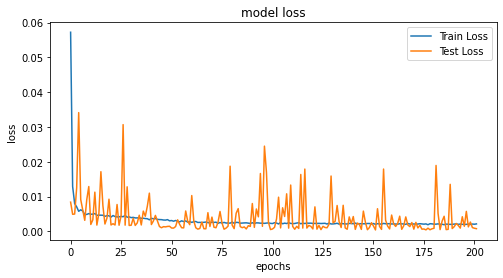

In [85]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [86]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.0200
MAPE on the test set: 17.8593
RMSE on the test set: 0.1414


In [87]:
y_pred=model.predict(X_test)

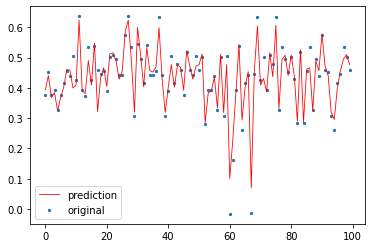

In [88]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()

In [61]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.GRU(20, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.GRU(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 20)             2220      
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 3,241
Trainable params: 3,241
Non-trainable params: 0
_________________________________________________________________


In [62]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=32,
            verbose=0,
            callbacks=[es])

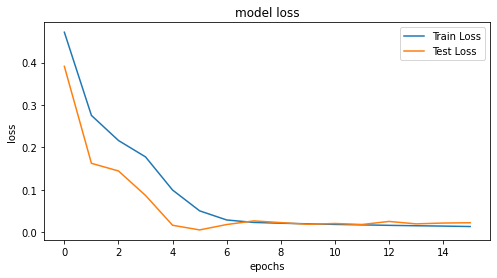

In [63]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [64]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.0777
MAPE on the test set: 81.1636
RMSE on the test set: 0.2788


In [65]:
y_pred=model.predict(X_test)

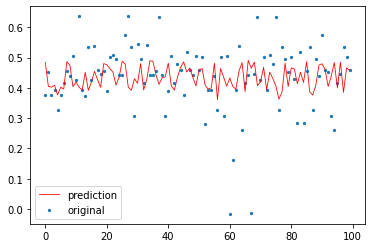

In [66]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()